# Tutorial 1: Getting Started with SQuADDS

In this tutorial, we will walk you through some basic usage of SQuADDS. By the end of this tutorial, you will be able to:

- Have an HuggingFace account

- Access the SQuADDS Database

- Use the SQuADDS API to query for closest and "best-guess" interpolated device designs for your chosen Hamiltonian parameters

- Simulate the "best-guess" design using an EM solver tool

In [1]:
%load_ext autoreload
%autoreload 2

Since the SQuADDS Database is hosted on [HuggingFace](https://huggingface.co/), we will need to create an account and get an API key to access the database.

## HuggingFace 🤗 

HuggingFace is a company that provides a large number of NLP models and datasets. They also provide a platform to host your own models and datasets.

### Creating an  Account

Follow the instructions here - [HuggingFace: Sign Up](https://huggingface.co/join) - to create an account.

Once you have created an account, you can get your API key from the [settings page](https://huggingface.co/settings/token).

Please update the `HUGGINGFACE_API_KEY` variable in the `.env` file with your API key **OR** execute the following code to set the environment variable.

In [2]:
from squadds.core.utils import set_huggingface_api_key

#set_huggingface_api_key()

 /Users/shanto/LFL/SQuADDS_Refactor/.venv/lib/python3.11/site-packages/tqdm/auto.py: 21

### Login

To login to your HuggingFace account, run the following command in your terminal:

```bash
huggingface-cli login
```



You will be prompted to enter your username and password. Once you have logged in, you can check your login status by running the following command:

```bash
huggingface-cli whoami
```

### Accessing the SQuADDS Database using the HuggingFace API

The SQuADDS Database is hosted on HuggingFace. You can access the database using the `datasets` library from HuggingFace.

In [3]:
from datasets import get_dataset_config_names, load_dataset

configs = get_dataset_config_names("SQuADDS/SQuADDS_DB")

INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/main/README.md "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/datasets/SQuADDS/SQuADDS_DB/6b4001554a05a484bcbb5faa7363f9c3097d5174/README.md "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://s3.amazonaws.com/datasets.huggingface.co/datasets/datasets/SQuADDS/SQuADDS_DB/SQuADDS/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/datasets/SQuADDS/SQuADDS_DB/revision/6b4001554a05a484bcbb5faa7363f9c3097d5174 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/.huggingface.yaml "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET https://

You can navigate the database using HuggingFace API. For example, you can access the qubit database using the following code:

In [4]:
qubit_data = load_dataset("SQuADDS/SQuADDS_DB", configs[0])

INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/main/README.md "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/datasets/SQuADDS/SQuADDS_DB/6b4001554a05a484bcbb5faa7363f9c3097d5174/README.md "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://s3.amazonaws.com/datasets.huggingface.co/datasets/datasets/SQuADDS/SQuADDS_DB/SQuADDS/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/.huggingface.yaml "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET https://datasets-server.huggingface.co/info?dataset=SQuADDS/SQuADDS_DB "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/S

In [5]:
qubit_data

DatasetDict({
    train: Dataset({
        features: ['sim_results', 'sim_options', 'design', 'notes', 'contributor'],
        num_rows: 1934
    })
})

Each configuration in the dataset is uniquely identified by their `config`. For the SQuADDS Database, the `config` string is created in the following format:

```python
config = f"{component}_{component_name}_{data_type}"
```

where `component` is the name of the component, `component_name` is the name of the component (in Qiskit Metal), and `data_type` is the type of simulation data that has been contributed.

Lets check what the `config` string looks like for our database:

In [6]:
components = []
component_names = []
data_types = []

for config in configs:
    try:
        components.append(config.split("-")[0])
        component_names.append(config.split("-")[1])
        data_types.append(config.split("-")[2])
    except:
        pass

print(components)
print(component_names)
print(data_types)


['qubit', 'cavity_claw', 'coupler', 'coupler', 'measured_device_database']
['TransmonCross', 'RouteMeander', 'NCap', 'CapNInterdigitalTee']
['cap_matrix', 'eigenmode', 'cap_matrix', 'cap_matrix']


The reason we added the `try except` block is because we have more datasets as well in the database that don't conform the simulation data format

## Using the SQuADDS API to access and anlyze the database

While it is possible to directly access the SQuADDS Database using the `datasets` library, we have created a simple API to make it easier to query the database.

The main object we use to access the database is the `SQuADDS_DB` class. 

In [7]:
from squadds import SQuADDS_DB

db = SQuADDS_DB()

INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/main/README.md "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/datasets/SQuADDS/SQuADDS_DB/6b4001554a05a484bcbb5faa7363f9c3097d5174/README.md "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://s3.amazonaws.com/datasets.huggingface.co/datasets/datasets/SQuADDS/SQuADDS_DB/SQuADDS/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/.huggingface.yaml "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET https://datasets-server.huggingface.co/info?dataset=SQuADDS/SQuADDS_DB "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/S

You can get a summary of the datasets by running.

In [8]:
db.view_datasets()

+-------------+---------------------+------------------+--------------------------------------------------------------------------------------------+
| Component   | Component Name      | Data Available   | Component Image                                                                            |
+=============+=====================+==================+============================================================================================+
| qubit       | TransmonCross       | cap_matrix       | https://github.com/LFL-Lab/SQuADDS/tree/master/docs/_static/images/TransmonCross.png       |
+-------------+---------------------+------------------+--------------------------------------------------------------------------------------------+
| coupler     | NCap                | cap_matrix       | https://github.com/LFL-Lab/SQuADDS/tree/master/docs/_static/images/NCap.png                |
+-------------+---------------------+------------------+--------------------------------------------

To check for the `config` names

In [9]:
db.get_configs()

['qubit-TransmonCross-cap_matrix',
 'cavity_claw-RouteMeander-eigenmode',
 'coupler-NCap-cap_matrix',
 'coupler-CapNInterdigitalTee-cap_matrix']


**NOTE: `'coupler-NCap-cap_matrix'` and `''coupler-CapNInterdigitalTee-cap_matrix'` are the same datasets. We will support them both since future releases will deprecate the term `NCap` and replace it with `CapNInterdigitalTee`.**

If you are interested to learn more about each configuration, you can do so by using the `get_dataset_info` method.


In [10]:
db.get_dataset_info(component="qubit", component_name="TransmonCross", data_type="cap_matrix")

INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/main/README.md "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/datasets/SQuADDS/SQuADDS_DB/6b4001554a05a484bcbb5faa7363f9c3097d5174/README.md "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://s3.amazonaws.com/datasets.huggingface.co/datasets/datasets/SQuADDS/SQuADDS_DB/SQuADDS/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/.huggingface.yaml "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET https://datasets-server.huggingface.co/info?dataset=SQuADDS/SQuADDS_DB "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/S

Dataset Features:
{'contributor': {'PI': Value('string'),
                 'date_created': Value('string'),
                 'group': Value('string'),
                 'institution': Value('string'),
                 'uploader': Value('string')},
 'design': {'design_options': {...}, 'design_tool': Value('string')},
 'notes': {},
 'sim_options': {'renderer_options': {...},
                 'setup': {...},
                 'simulator': Value('string')},
 'sim_results': {'claw_to_claw': Value('float64'),
                 'claw_to_ground': Value('float64'),
                 'cross_to_claw': Value('float64'),
                 'cross_to_cross': Value('float64'),
                 'cross_to_ground': Value('float64'),
                 'ground_to_ground': Value('float64'),
                 'units': Value('string')}}

Dataset Description:


Dataset Citation:


Dataset Homepage:


Dataset License:


Dataset Size in Bytes:
9735651


In [11]:
db.get_dataset_info(component="cavity_claw", component_name="RouteMeander", data_type="eigenmode")

INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/main/README.md "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/datasets/SQuADDS/SQuADDS_DB/6b4001554a05a484bcbb5faa7363f9c3097d5174/README.md "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://s3.amazonaws.com/datasets.huggingface.co/datasets/datasets/SQuADDS/SQuADDS_DB/SQuADDS/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/.huggingface.yaml "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET https://datasets-server.huggingface.co/info?dataset=SQuADDS/SQuADDS_DB "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/S

Dataset Features:
{'contributor': {'PI': Value('string'),
                 'date_created': Value('string'),
                 'group': Value('string'),
                 'institution': Value('string'),
                 'misc': Value('string'),
                 'uploader': Value('string')},
 'design': {'coupler_type': Value('string'),
            'design_options': {...},
            'design_tool': Value('string'),
            'resonator_type': Value('string')},
 'notes': {},
 'sim_options': {'renderer_options': {...},
                 'setup': {...},
                 'simulator': Value('string')},
 'sim_results': {'cavity_frequency': Value('float64'),
                 'kappa': Value('float64'),
                 'units': Value('string')}}

Dataset Description:


Dataset Citation:


Dataset Homepage:


Dataset License:


Dataset Size in Bytes:
4620074


You can get the entire dataset as a Pandas DataFrame by using the `get_dataset` method.

In [12]:
db.see_dataset(component="qubit", component_name="TransmonCross", data_type="cap_matrix")

INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/main/README.md "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/datasets/SQuADDS/SQuADDS_DB/6b4001554a05a484bcbb5faa7363f9c3097d5174/README.md "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://s3.amazonaws.com/datasets.huggingface.co/datasets/datasets/SQuADDS/SQuADDS_DB/SQuADDS/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/.huggingface.yaml "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET https://datasets-server.huggingface.co/info?dataset=SQuADDS/SQuADDS_DB "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/S

claw_to_claw  claw_to_ground  cross_to_claw  cross_to_cross  \
0         94.97421        90.86585        3.73363       158.40783   
1         82.44280        79.19378        2.93820       188.15089   
2         83.76412        80.18130        3.16131       104.35340   
3        103.37057        97.22405        5.77590       174.13928   
4         68.92854        65.68607        2.87375       120.03923   
...            ...             ...            ...             ...   
1929     106.43025       101.53197        4.45645       174.46380   
1930     121.10943       112.62570        7.95178       187.43537   
1931     144.56289       136.36810        7.65968       172.14561   
1932      68.76413        65.78116        2.48795        56.75230   
1933      58.45749        55.50796        2.54396        62.01000   

      cross_to_ground  ground_to_ground units  \
0           158.40783         311.25590    fF   
1           188.15089         333.52997    fF   
2           104.35340         237.02548    fF   
3           174.13928         335.31609    fF   
4           120.03923         240.34085    fF   
...               ...               ...   ...   
1929        174.46380         340.62919    fF   
1930        187.43537         367.34003    fF   
1931        172.14561         372.39970    fF   
1932         56.75230         166.57383    fF   
1933         62.01000         162.42140    fF   

                                       renderer_options  \
0     {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
1     {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
2     {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
3     {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
4     {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
...                                                 ...   
1929  {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
1930  {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
1931  {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
1932  {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
1933  {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   

                                                  setup   simulator  \
0     {'auto_increase_solution_order': True, 'enable...  Ansys HFSS   
1     {'auto_increase_solution_order': True, 'enable...  Ansys HFSS   
2     {'auto_increase_solution_order': True, 'enable...  Ansys HFSS   
3     {'auto_increase_solution_order': True, 'enable...  Ansys HFSS   
4     {'auto_increase_solution_order': True, 'enable...  Ansys HFSS   
...                                                 ...         ...   
1929  {'auto_increase_solution_order': True, 'enable...  Ansys HFSS   
1930  {'auto_increase_solution_order': True, 'enable...  Ansys HFSS   
1931  {'auto_increase_solution_order': True, 'enable...  Ansys HFSS   
1932  {'auto_increase_solution_order': True, 'enable...  Ansys HFSS   
1933  {'auto_increase_solution_order': True, 'enable...  Ansys HFSS   

                                         design_options   design_tool  \
0     {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...  qiskit-metal   
1     {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...  qiskit-metal   
2     {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...  qiskit-metal   
3     {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...  qiskit-metal   
4     {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...  qiskit-metal   
...                                                 ...           ...   
1929  {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...  qiskit-metal   
1930  {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...  qiskit-metal   
1931  {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...  qiskit-metal   
1932  {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...  qiskit-metal   
1933  {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...  qiskit-metal   

                          PI       date_created group institution   uploader  
0     Eli Levenson-Falk, PhD  2023-09-20-142547   LFL         USC  And

You can also learn more about the measured device that generated this dataset:

In [13]:
db.view_reference_device_of(component="qubit", component_name="TransmonCross", data_type="cap_matrix")

INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/main/README.md "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/datasets/SQuADDS/SQuADDS_DB/6b4001554a05a484bcbb5faa7363f9c3097d5174/README.md "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://s3.amazonaws.com/datasets.huggingface.co/datasets/datasets/SQuADDS/SQuADDS_DB/SQuADDS/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/.huggingface.yaml "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET https://datasets-server.huggingface.co/info?dataset=SQuADDS/SQuADDS_DB "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/S

+--------------------+------------------------------------------------------------------------------------+
| Design Code        | https://github.com/LFL-Lab/design_schema_WM1                                       |
+--------------------+------------------------------------------------------------------------------------+
| Paper Link         | https://arxiv.org/pdf/2312.13483                                                   |
+--------------------+------------------------------------------------------------------------------------+
| Image              | https://github.com/LFL-Lab/design_schema_WM1/blob/main/assets/WM1_qiskit_metal.png |
+--------------------+------------------------------------------------------------------------------------+
| Foundry            | SQUILL                                                                             |
+--------------------+------------------------------------------------------------------------------------+
| Fabrication Recipe | Confi

You can also learn more about the other measured devices that are available in SQuADDS

In [14]:
db.get_measured_devices()

INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/main/README.md "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/datasets/SQuADDS/SQuADDS_DB/6b4001554a05a484bcbb5faa7363f9c3097d5174/README.md "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://s3.amazonaws.com/datasets.huggingface.co/datasets/datasets/SQuADDS/SQuADDS_DB/SQuADDS/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/.huggingface.yaml "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET https://datasets-server.huggingface.co/info?dataset=SQuADDS/SQuADDS_DB "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/S

Name                                        Design Code  \
0           WM1       https://github.com/LFL-Lab/design_schema_WM1   
1  “dissipator”  https://github.com/LFL-Lab/design_schema_dissi...   
2        MUNNIN    https://github.com/LFL-Lab/design_schema_MUNNIN   

                                          Paper Link  \
0                   https://arxiv.org/pdf/2312.13483   
1  https://journals.aps.org/prxquantum/abstract/1...   
2  https://journals.aps.org/prl/abstract/10.1103/...   

                                               Image      Foundry  \
0  https://github.com/LFL-Lab/design_schema_WM1/b...       SQUILL   
1  https://github.com/LFL-Lab/design_schema_dissi...  USC Nanofab   
2  https://github.com/LFL-Lab/design_schema_MUNNI...       SQUILL   

     Substrate  Materials Junction Style Junction Materials  
0      Silicon  Aluminium          Dolan         Al-AlOx-Al  
1  Silicon 111  Aluminium      Manhattan         Al-AlOx-Al  
2      Silicon  Aluminium          Dolan         Al-AlOx-Al

If you want to learn about the who contributed the simulation data, you can use the following methods:

In [15]:
db.view_contributors_of("qubit", "TransmonCross", "cap_matrix")

INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/main/README.md "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/datasets/SQuADDS/SQuADDS_DB/6b4001554a05a484bcbb5faa7363f9c3097d5174/README.md "HTTP/1.1 200 OK"


			Measured Device Contributor(s):


INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://s3.amazonaws.com/datasets.huggingface.co/datasets/datasets/SQuADDS/SQuADDS_DB/SQuADDS/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/.huggingface.yaml "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET https://datasets-server.huggingface.co/info?dataset=SQuADDS/SQuADDS_DB "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/dataset_infos.json "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/main/README.md "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-

+-----------------------+-------------------------------------------------------+
| Foundry               | N/A                                                   |
+-----------------------+-------------------------------------------------------+
| PI                    | Eli Levenson-Falk, PhD                                |
+-----------------------+-------------------------------------------------------+
| Group                 | LFL                                                   |
+-----------------------+-------------------------------------------------------+
| Institution           | USC                                                   |
+-----------------------+-------------------------------------------------------+
| Measured By           | Sadman Ahmed Shanto, Malinda Hecht, Evangelos Vlachos |
+-----------------------+-------------------------------------------------------+
| Reference Device Name | WM1                                                   |
+---------------

INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://s3.amazonaws.com/datasets.huggingface.co/datasets/datasets/SQuADDS/SQuADDS_DB/SQuADDS/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/.huggingface.yaml "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET https://datasets-server.huggingface.co/info?dataset=SQuADDS/SQuADDS_DB "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/dataset_infos.json "HTTP/1.1 404 Not Found"


+------------+------------------------+---------+---------------+
| uploader   | PI                     | group   | institution   |
+============+========================+=========+===============+
| Andre Kuo  | Eli Levenson-Falk, PhD | LFL     | USC           |
+------------+------------------------+---------+---------------+


To see the list of all the contributors, you can use the following method:

In [16]:
db.view_all_contributors()

+-----------------------+------------------------------------+-------------------------------------------+
| Name                  | Institution                        | Contribution                              |
+=======================+====================================+===========================================+
| Clark Miyamoto        | New York University                | Code contributor 💻                       |
+-----------------------+------------------------------------+-------------------------------------------+
| Madison Howard        | California Institute of Technology | Bug Hunter 🐛                             |
+-----------------------+------------------------------------+-------------------------------------------+
| Evangelos Vlachos     | University of Southern California  | Code contributor 💻                       |
+-----------------------+------------------------------------+-------------------------------------------+
| Kaveh Pezeshki        | Stanford Unive

As the SQuADDS_DB dataset updates, so will all the information we have queried automatically. 

## Making Systems out of Circuit QED Elements

One of the main use cases of the SQuADDS project is to get the design space parameters for systems of our interest using our desired Hamiltonian parameters.

Using the SQuADDS API, we can "build" a system by choosing the circuit QED components we want to use.

The following subsections walks you through some examples.

### Querying for the a target qubit design

Let's say you know the Hamiltonian parameters of a qubit you want to use. You can use the SQuADDS API to query for the closest design to your target qubit.

We first need to select our sytem of interest.

In [17]:
db.select_system("qubit")

Now, we need to specify to SQuADDS what type of `qubit` our system is. We can do this by using the `select_qubit` method.

In [18]:
db.select_qubit("TransmonCross")

We now create the system dataframe so that we can query for the design parameters we are interested in.

In [19]:
df = db.create_system_df()
df

INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/main/README.md "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/datasets/SQuADDS/SQuADDS_DB/6b4001554a05a484bcbb5faa7363f9c3097d5174/README.md "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://s3.amazonaws.com/datasets.huggingface.co/datasets/datasets/SQuADDS/SQuADDS_DB/SQuADDS/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/.huggingface.yaml "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET https://datasets-server.huggingface.co/info?dataset=SQuADDS/SQuADDS_DB "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/S

claw_to_claw  claw_to_ground  cross_to_claw  cross_to_cross  \
0         94.97421        90.86585        3.73363       158.40783   
1         82.44280        79.19378        2.93820       188.15089   
2         83.76412        80.18130        3.16131       104.35340   
3        103.37057        97.22405        5.77590       174.13928   
4         68.92854        65.68607        2.87375       120.03923   
...            ...             ...            ...             ...   
1929     106.43025       101.53197        4.45645       174.46380   
1930     121.10943       112.62570        7.95178       187.43537   
1931     144.56289       136.36810        7.65968       172.14561   
1932      68.76413        65.78116        2.48795        56.75230   
1933      58.45749        55.50796        2.54396        62.01000   

      cross_to_ground  ground_to_ground units  \
0           158.40783         311.25590    fF   
1           188.15089         333.52997    fF   
2           104.35340         237.02548    fF   
3           174.13928         335.31609    fF   
4           120.03923         240.34085    fF   
...               ...               ...   ...   
1929        174.46380         340.62919    fF   
1930        187.43537         367.34003    fF   
1931        172.14561         372.39970    fF   
1932         56.75230         166.57383    fF   
1933         62.01000         162.42140    fF   

                                       renderer_options  \
0     {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
1     {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
2     {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
3     {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
4     {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
...                                                 ...   
1929  {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
1930  {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
1931  {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
1932  {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
1933  {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   

                                                  setup   simulator  \
0     {'auto_increase_solution_order': True, 'enable...  Ansys HFSS   
1     {'auto_increase_solution_order': True, 'enable...  Ansys HFSS   
2     {'auto_increase_solution_order': True, 'enable...  Ansys HFSS   
3     {'auto_increase_solution_order': True, 'enable...  Ansys HFSS   
4     {'auto_increase_solution_order': True, 'enable...  Ansys HFSS   
...                                                 ...         ...   
1929  {'auto_increase_solution_order': True, 'enable...  Ansys HFSS   
1930  {'auto_increase_solution_order': True, 'enable...  Ansys HFSS   
1931  {'auto_increase_solution_order': True, 'enable...  Ansys HFSS   
1932  {'auto_increase_solution_order': True, 'enable...  Ansys HFSS   
1933  {'auto_increase_solution_order': True, 'enable...  Ansys HFSS   

                                         design_options   design_tool  \
0     {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...  qiskit-metal   
1     {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...  qiskit-metal   
2     {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...  qiskit-metal   
3     {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...  qiskit-metal   
4     {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...  qiskit-metal   
...                                                 ...           ...   
1929  {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...  qiskit-metal   
1930  {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...  qiskit-metal   
1931  {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...  qiskit-metal   
1932  {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...  qiskit-metal   
1933  {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...  qiskit-metal   

                          PI       date_created group institution   uploader  
0     Eli Levenson-Falk, PhD  2023-09-20-142547   LFL         USC  And

Now that we have created our system dataframe, we can query for the closest design to our target qubit parameters. To do this we need to call the `Analyzer` object.

In [20]:
from squadds import Analyzer

We instatantaite the `Analyzer` object by passing in the `SQuADDS_DB` instance we created earlier.

In [21]:
analyzer = Analyzer(db)

We can now check for what type of Hamiltonian parameters are available for our chosen system

In [22]:
analyzer.target_param_keys()

['qubit_frequency_GHz', 'anharmonicity_MHz']

Now, Let's select a geometry which results in the closest qubit characteristics

Call `Analyzer.find_closest`

**Documentation:**

```
Finds the rows in the DataFrame with the closest matching characteristics
to the given target parameters using a specified metric.

Args:
    target_params (dict): A dictionary containing the target values for columns in `self.df`.
                          Keys are column names and values are the target values.
    num_top (int): The number of closest matching rows to return.
    metric (str, optional): The distance metric to use for finding the closest matches.
                            Available options are specified in `self.__supported_metrics__`.
                            Defaults to 'Euclidean'.
    display (bool, optional): Whether to display warnings and logs. Defaults to True.

Returns:
    pd.DataFrame: A DataFrame containing the rows with the closest matching characteristics,
                  sorted by the distance metric.

Raises:
    ValueError: If the specified metric is not supported or `num_top` exceeds the DataFrame size.
```

You are given the choice of the following metrics.

In [23]:
analyzer.__supported_metrics__

['Euclidean', 'Manhattan', 'Chebyshev', 'Weighted Euclidean', 'Custom']

Define your Hamiltonian parameters that you want to use for your qubit 

In [24]:
target_params={"qubit_frequency_GHz": 4, "anharmonicity_MHz": -200}

In [25]:
results = analyzer.find_closest(target_params=target_params,
                                       num_top=3,
                                       metric="Euclidean",
                                       display=True)
results

claw_to_claw  claw_to_ground  cross_to_claw  cross_to_cross  \
643      106.91739       101.13161        5.25204       102.49025   
1862      80.01554        76.72741        2.89095       104.64079   
1714      76.27207        73.26136        2.62986       104.89818   

      cross_to_ground  ground_to_ground units  \
643         102.49025         255.94708    fF   
1862        104.64079         233.88902    fF   
1714        104.89818         230.69451    fF   

                                       renderer_options  \
643   {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
1862  {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
1714  {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   

                                                  setup   simulator  ...  \
643   {'auto_increase_solution_order': True, 'enable...  Ansys HFSS  ...   
1862  {'auto_increase_solution_order': True, 'enable...  Ansys HFSS  ...   
1714  {'auto_increase_solution_order': True, 'enable...  Ansys HFSS  ...   

       design_tool                      PI       date_created group  \
643   qiskit-metal  Eli Levenson-Falk, PhD  2023-09-20-142547   LFL   
1862  qiskit-metal  Eli Levenson-Falk, PhD  2023-09-20-142547   LFL   
1714  qiskit-metal  Eli Levenson-Falk, PhD  2023-09-20-142547   LFL   

     institution   uploader        EC         EJ  qubit_frequency_GHz  \
643          USC  Andre Kuo  0.179783  12.278081             4.013772   
1862         USC  Andre Kuo  0.180135  12.278081             4.017505   
1714         USC  Andre Kuo  0.180141  12.278081             4.017568   

      anharmonicity_MHz  
643         -201.551563  
1862        -201.973606  
1714        -201.980800  

[3 rows x 21 columns]

Thats it! You have now found some designs for your qubit that are closest to your target Hamiltonian parameters.

#### Using Custom Metrics

To use a custom metric first define the function. For example, lets say we want the manhattan metric

In [26]:
def manhattan_distance(target, simulated):
    return sum(abs(target[key] - simulated.get(key, 0)) for key in target)

In [27]:
analyzer.custom_metric_func = manhattan_distance

In [28]:
analyzer.find_closest(target_params=target_params,
                                            num_top=1,
                                            metric="Custom",
                                            display=True)

Either `skip_df_gen` flag is set to True or all target params have been precomputed at an earlier step. Using `df` from memory.
Please set this to False if `target_parameters` have changed.


claw_to_claw  claw_to_ground  cross_to_claw  cross_to_cross  \
643     106.91739       101.13161        5.25204       102.49025   

     cross_to_ground  ground_to_ground units  \
643        102.49025         255.94708    fF   

                                      renderer_options  \
643  {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   

                                                 setup   simulator  ...  \
643  {'auto_increase_solution_order': True, 'enable...  Ansys HFSS  ...   

      design_tool                      PI       date_created group  \
643  qiskit-metal  Eli Levenson-Falk, PhD  2023-09-20-142547   LFL   

    institution   uploader        EC         EJ  qubit_frequency_GHz  \
643         USC  Andre Kuo  0.179783  12.278081             4.013772   

     anharmonicity_MHz  
643        -201.551563  

[1 rows x 21 columns]

In [29]:
best_options = results.iloc[0]["design_options"]
best_options

{'aedt_hfss_capacitance': 0,
 'aedt_hfss_inductance': 9.686e-09,
 'aedt_q3d_capacitance': 0,
 'aedt_q3d_inductance': 1e-08,
 'chip': 'main',
 'connection_pads': {'readout': {'claw_cpw_length': '40um',
   'claw_cpw_width': '10um',
   'claw_gap': '5.1um',
   'claw_length': '190um',
   'claw_width': '15um',
   'connector_location': '90',
   'connector_type': '0',
   'ground_spacing': '10um'}},
 'cross_gap': '30um',
 'cross_length': '210um',
 'cross_width': '30um',
 'gds_cell_name': 'my_other_junction',
 'hfss_capacitance': 0,
 'hfss_inductance': 9.686e-09,
 'hfss_mesh_kw_jj': 7e-06,
 'hfss_resistance': 0,
 'layer': '1',
 'orientation': '-90',
 'pos_x': '-1500um',
 'pos_y': '1200um',
 'q3d_capacitance': 0,
 'q3d_inductance': '10nH',
 'q3d_mesh_kw_jj': 7e-06,
 'q3d_resistance': 0}

You can pass in the `design_options` from the closest design to the `options` argument of your selected qubit and render it in qiskit metal.

In [30]:
# Qiskit Metal imports
import qiskit_metal as metal
from qiskit_metal import MetalGUI
from qiskit_metal.designs.design_multiplanar import MultiPlanar
from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross

In [31]:
design = MultiPlanar(metadata={},
                     overwrite_enabled=True)
gui = MetalGUI(design)

 /Users/shanto/LFL/SQuADDS_Refactor/.venv/lib/python3.11/site-packages/qiskit_metal/qgeometries/qgeometries_handler.py: 528
 /Users/shanto/LFL/SQuADDS_Refactor/.venv/lib/python3.11/site-packages/qiskit_metal/renderers/renderer_mpl/mpl_renderer.py: 281


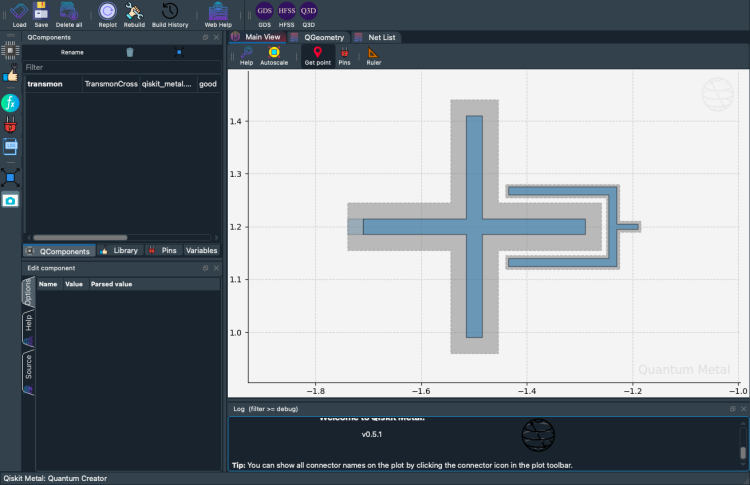

In [32]:

TransmonCross(design, "transmon", options=best_options)

gui.rebuild()
gui.zoom_on_components(['transmon'])
gui.screenshot("qubit_only.png")

### Querying for a target cavity design

The same workflow can be used to query for a target cavity design.

While it is not necessary, it may be a good idea to `unselect_all()` before creating a new system.

In [33]:
db.unselect_all()

Proceed with selecting the system of interest

In [34]:
db.select_system("cavity_claw")

In [35]:
db.select_cavity_claw("RouteMeander")

In [36]:
db.select_resonator_type("quarter")

It's always a good idea to check that the system you have selected is correct.

In [37]:
db.show_selections()

Selected component:  cavity_claw
Selected component name:  RouteMeander
Selected data type:  eigenmode
Selected system:  cavity_claw
Selected coupler:  CLT
Selected resonator type:  quarter


Great! lets create the system dataframe and analyze it.

In [38]:
df = db.create_system_df()

INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/main/README.md "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/datasets/SQuADDS/SQuADDS_DB/6b4001554a05a484bcbb5faa7363f9c3097d5174/README.md "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://s3.amazonaws.com/datasets.huggingface.co/datasets/datasets/SQuADDS/SQuADDS_DB/SQuADDS/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/.huggingface.yaml "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET https://datasets-server.huggingface.co/info?dataset=SQuADDS/SQuADDS_DB "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/S

In [39]:
analyzer = Analyzer(db)

In [40]:
analyzer.target_param_keys()

['resonator_type', 'cavity_frequency_GHz', 'kappa_kHz']

Select the Hamiltonian parameters you want to use for your cavity and search for the closest designs.

In [41]:
target_params = {"cavity_frequency_GHz": 6.9,
                "kappa_kHz": 120,
                "resonator_type":"quarter"}

In [42]:
results = analyzer.find_closest(target_params=target_params,
                                       num_top=5,
                                       metric="Euclidean",
                                       display=True)
results

renderer_options                                              setup  \
1191             None  {'basis_order': 1, 'max_delta_f': 0.05, 'max_p...   
1192             None  {'basis_order': 1, 'max_delta_f': 0.05, 'max_p...   
1189             None  {'basis_order': 1, 'max_delta_f': 0.05, 'max_p...   
190              None  {'basis_order': 1, 'max_delta_f': 0.05, 'max_p...   
1190             None  {'basis_order': 1, 'max_delta_f': 0.05, 'max_p...   

       simulator  cavity_frequency_GHz   kappa_kHz coupler_type  \
1191  Ansys HFSS              6.948003  122.218952          CLT   
1192  Ansys HFSS              6.915761  125.765213          CLT   
1189  Ansys HFSS              7.013518  127.327511          CLT   
190   Ansys HFSS              6.371017  121.824395          CLT   
1190  Ansys HFSS              6.980933  129.751169          CLT   

                                         design_options   design_tool  \
1191  {'claw_opts': {'connection_pads': {'readout': ...  qiskit-metal   
1192  {'claw_opts': {'connection_pads': {'readout': ...  qiskit-metal   
1189  {'claw_opts': {'connection_pads': {'readout': ...  qiskit-metal   
190   {'claw_opts': {'connection_pads': {'readout': ...  qiskit-metal   
1190  {'claw_opts': {'connection_pads': {'readout': ...  qiskit-metal   

     resonator_type                      PI       date_created group  \
1191        quarter  Eli Levenson-Falk, PhD  2024-07-24-230000   LFL   
1192        quarter  Eli Levenson-Falk, PhD  2024-07-24-230000   LFL   
1189        quarter  Eli Levenson-Falk, PhD  2024-07-24-230000   LFL   
190         quarter  Eli Levenson-Falk, PhD  2023-11-30-214122   LFL   
1190        quarter  Eli Levenson-Falk, PhD  2024-07-24-230000   LFL   

     institution  misc     uploader  
1191         USC  None  Ethan Zheng  
1192         USC  None  Ethan Zheng  
1189         USC  None  Ethan Zheng  
190          USC  None    Andre Kuo  
1190         USC  None  Ethan Zheng

Lets say we want to use the "Weighted Euclidean" metric to find the closest design to our target cavity parameters.

#### Weighted Euclidean Metric

You can do a weighted Euclidean metric instead.

$$
F(\{P_i\},\{p_i\}) = \sum_i w_i\frac{(P_i - p_i)^2}{P_i^2}
$$

Here \( w_i \) are weights which default to 1 if not user-defined.

Note: The default metric for `find_closest` is `Euclidean` when not user-defined.


In [43]:
# Set up the weights
analyzer.metric_weights = {"cavity_frequency_GHz": 2, "kappa_kHz": 1}

In [44]:
results = analyzer.find_closest(target_params=target_params,
                                       num_top=3,
                                       metric="Weighted Euclidean",
                                       display=True)
results

renderer_options                                              setup  \
1191             None  {'basis_order': 1, 'max_delta_f': 0.05, 'max_p...   
1192             None  {'basis_order': 1, 'max_delta_f': 0.05, 'max_p...   
1189             None  {'basis_order': 1, 'max_delta_f': 0.05, 'max_p...   

       simulator  cavity_frequency_GHz   kappa_kHz coupler_type  \
1191  Ansys HFSS              6.948003  122.218952          CLT   
1192  Ansys HFSS              6.915761  125.765213          CLT   
1189  Ansys HFSS              7.013518  127.327511          CLT   

                                         design_options   design_tool  \
1191  {'claw_opts': {'connection_pads': {'readout': ...  qiskit-metal   
1192  {'claw_opts': {'connection_pads': {'readout': ...  qiskit-metal   
1189  {'claw_opts': {'connection_pads': {'readout': ...  qiskit-metal   

     resonator_type                      PI       date_created group  \
1191        quarter  Eli Levenson-Falk, PhD  2024-07-24-230000   LFL   
1192        quarter  Eli Levenson-Falk, PhD  2024-07-24-230000   LFL   
1189        quarter  Eli Levenson-Falk, PhD  2024-07-24-230000   LFL   

     institution  misc     uploader  
1191         USC  None  Ethan Zheng  
1192         USC  None  Ethan Zheng  
1189         USC  None  Ethan Zheng

### Querying for a target qubit-cavity design

Again, we follow the same procedure as before.

In [45]:
db.select_system(["qubit","cavity_claw"])

In [46]:
db.select_qubit("TransmonCross")
db.select_cavity_claw("RouteMeander")
db.select_resonator_type("quarter")

In [47]:
db.show_selections()

Selected qubit:  TransmonCross
Selected cavity:  RouteMeander
Selected coupler to feedline:  CLT
Selected resonator type:  quarter
Selected system:  ['qubit', 'cavity_claw']


In [48]:
merged_df = db.create_system_df()

INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/main/README.md "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/datasets/SQuADDS/SQuADDS_DB/6b4001554a05a484bcbb5faa7363f9c3097d5174/README.md "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://s3.amazonaws.com/datasets.huggingface.co/datasets/datasets/SQuADDS/SQuADDS_DB/SQuADDS/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/.huggingface.yaml "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET https://datasets-server.huggingface.co/info?dataset=SQuADDS/SQuADDS_DB "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/S

In [49]:
merged_df

index_qc  claw_to_claw  claw_to_ground  cross_to_claw  cross_to_cross  \
0             0      94.97421        90.86585        3.73363       158.40783   
1             0      94.97421        90.86585        3.73363       158.40783   
2             0      94.97421        90.86585        3.73363       158.40783   
3             0      94.97421        90.86585        3.73363       158.40783   
4             0      94.97421        90.86585        3.73363       158.40783   
...         ...           ...             ...            ...             ...   
22191      1933      58.45749        55.50796        2.54396        62.01000   
22192      1933      58.45749        55.50796        2.54396        62.01000   
22193      1933      58.45749        55.50796        2.54396        62.01000   
22194      1933      58.45749        55.50796        2.54396        62.01000   
22195      1933      58.45749        55.50796        2.54396        62.01000   

       cross_to_ground  ground_to_ground units_qubit  \
0            158.40783          311.2559          fF   
1            158.40783          311.2559          fF   
2            158.40783          311.2559          fF   
3            158.40783          311.2559          fF   
4            158.40783          311.2559          fF   
...                ...               ...         ...   
22191         62.01000          162.4214          fF   
22192         62.01000          162.4214          fF   
22193         62.01000          162.4214          fF   
22194         62.01000          162.4214          fF   
22195         62.01000          162.4214          fF   

                                  renderer_options_qubit  \
0      {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
1      {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
2      {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
3      {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
4      {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
...                                                  ...   
22191  {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
22192  {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
22193  {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
22194  {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
22195  {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   

                                             setup_qubit  ...  \
0      {'auto_increase_solution_order': True, 'enable...  ...   
1      {'auto_increase_solution_order': True, 'enable...  ...   
2      {'auto_increase_solution_order': True, 'enable...  ...   
3      {'auto_increase_solution_order': True, 'enable...  ...   
4      {'auto_increase_solution_order': True, 'enable...  ...   
...                                                  ...  ...   
22191  {'auto_increase_solution_order': True, 'enable...  ...   
22192  {'auto_increase_solution_order': True, 'enable...  ...   
22193  {'auto_increase_solution_order': True, 'enable...  ...   
22194  {'auto_increase_solution_order': True, 'enable...  ...   
22195  {'auto_increase_solution_order': True, 'enable...  ...   

                              design_options_cavity_claw  \
0      {'claw_opts': {'connection_pads': {'readout': ...   
1      {'claw_opts': {'connection_pads': {'readout': ...   
2      {'claw_opts': {'connection_pads': {'readout': ...   
3      {'claw_opts': {'connection_pads': {'readout': ...   
4      {'claw_opts': {'connection_pads': {'readout': ...   
...                                                  ...   
22191  {'claw_opts': {'connection_pads': {'readout': ...   
22192  {'claw_opts': {'connection_pads': {'readout': ...   
22193  {'claw_opts': {'connection_pads': {'readout': ...   
22194  {'claw_opts': {'connection_pads': {'readout': ...   
22195  {'claw_opts': {'connection_pads': {'readout': ...   

      design_tool_cavity_claw resonator_type          PI_cavity_claw  \
0                qiskit-metal        quarter  Eli Levenson-Falk, PhD   
1     

Pass the `SQuADDS_DB` instance to the `Analyzer` object.

In [50]:
analyzer = Analyzer(db)

Always good to check whether the system you have selected is correct.

In [51]:
db.selected_system

['qubit', 'cavity_claw']

In [52]:
analyzer.selected_system

['qubit', 'cavity_claw']

Define the `target_params` for your qubit-cavity system.

In [53]:
target_params = {
                "qubit_frequency_GHz": 4,
                "cavity_frequency_GHz": 6.2,
                "kappa_kHz": 120,
                "resonator_type":"quarter",
                "anharmonicity_MHz": -200,
                "g_MHz": 70}

In [54]:
results = analyzer.find_closest(target_params=target_params,
                                       num_top=3,
                                       metric="Euclidean",
                                       display=True)
results

Time taken to add the coupled H params: 0.5193672180175781 seconds


index_qc  claw_to_claw  claw_to_ground  cross_to_claw  cross_to_cross  \
16535      1441     113.99245       107.65111        5.75841       112.70740   
9252        812     105.76081        99.80185        5.38260       100.41444   
13522      1180     109.80541       103.57639        5.68548       105.83609   

       cross_to_ground  ground_to_ground units_qubit  \
16535        112.70740         274.49373          fF   
9252         100.41444         251.82560          fF   
13522        105.83609         261.84982          fF   

                                  renderer_options_qubit  \
16535  {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
9252   {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   
13522  {'Cj': 0, 'Lj': '10nH', '_Rj': 0, 'design_name...   

                                             setup_qubit  ...  \
16535  {'auto_increase_solution_order': True, 'enable...  ...   
9252   {'auto_increase_solution_order': True, 'enable...  ...   
13522  {'auto_increase_solution_order': True, 'enable...  ...   

      group_cavity_claw institution_cavity_claw  misc uploader_cavity_claw  \
16535               LFL                     USC  None            Andre Kuo   
9252                LFL                     USC  None            Andre Kuo   
13522               LFL                     USC  None            Andre Kuo   

                                          design_options        EC         EJ  \
16535  {'cavity_claw_options': {'coupler_type': 'CLT'...  0.163509  12.278081   
9252   {'cavity_claw_options': {'coupler_type': 'CLT'...  0.183089  12.278081   
13522  {'cavity_claw_options': {'coupler_type': 'CLT'...  0.173690  12.278081   

      qubit_frequency_GHz anharmonicity_MHz      g_MHz  
16535            3.836546       -182.146811  68.095121  
9252             4.048674       -205.519307  70.226899  
13522            3.948501       -194.261783  70.978895  

[3 rows x 41 columns]

Awesome! we have some designs for our qubit-cavity system. To see where the closest design lies in the Hamiltonian parameter space, we can use the `closest_design_in_H_space` method.

In [55]:
%matplotlib inline

In [56]:
analyzer.closest_design_in_H_space()

Similarly, we can query for the best-guess design for our qubit-cavity system with a half-wave resonator.

Lets start by selecting the system of interest and creating the system dataframe.

In [57]:
db.unselect_all()
db.select_system(["qubit", "cavity_claw"])
db.select_qubit("TransmonCross")
db.select_cavity_claw("RouteMeander")
db.select_resonator_type("half")
db.show_selections()
half_df = db.create_system_df()

INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/main/README.md "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-cache/datasets/SQuADDS/SQuADDS_DB/6b4001554a05a484bcbb5faa7363f9c3097d5174/README.md "HTTP/1.1 200 OK"


Selected qubit:  TransmonCross
Selected cavity:  RouteMeander
Selected coupler to feedline:  NCap
Selected resonator type:  half
Selected system:  ['qubit', 'cavity_claw']


INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://s3.amazonaws.com/datasets.huggingface.co/datasets/datasets/SQuADDS/SQuADDS_DB/SQuADDS/SQuADDS_DB.py "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/.huggingface.yaml "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: GET https://datasets-server.huggingface.co/info?dataset=SQuADDS/SQuADDS_DB "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/6b4001554a05a484bcbb5faa7363f9c3097d5174/dataset_infos.json "HTTP/1.1 404 Not Found"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/datasets/SQuADDS/SQuADDS_DB/resolve/main/README.md "HTTP/1.1 307 Temporary Redirect"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/api/resolve-

Now, lets pass on our new system info to the `Analyzer` object. We can either re-instantiate the `Analyzer` object like before.

```python
analyzer_hdf = Analyzer(db)
```

Or we can just update the `analyzer` object with the new system info using the following method.

In [58]:
analyzer.reload_db()

Doing a sanity check to see if the system we have selected is correct.

In [59]:
analyzer.db.show_selections()

Selected qubit:  TransmonCross
Selected cavity:  RouteMeander
Selected coupler to feedline:  NCap
Selected resonator type:  half
Selected system:  ['qubit', 'cavity_claw']


Great! Now lets query for the best-guess design for our system. 

In [60]:
target_params = {
                "qubit_frequency_GHz": 4,
                "cavity_frequency_GHz": 9.2,
                "kappa_kHz": 80,
                "resonator_type":"half",
                "anharmonicity_MHz": -200,
                "g_MHz": 70}

results = analyzer.find_closest(target_params=target_params, num_top=1, metric="Euclidean", parallel=True, num_cpu="auto")

Using 10 chunks for parallel processing
Computing transmon params for 1299 unique EC values...
Pre-computed 1299 unique transmon states


 /Users/shanto/LFL/SQuADDS_Refactor/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py: 59
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../squadds/calcs/transmon_cross.py", line 108:
@jit(nopython=True, parallel=True)
def g_from_cap_matrix_numba(C, C_c, EJ, f_r, res_type, Z0=50):
^

 /Users/shanto/LFL/SQuADDS_Refactor/.venv/lib/python3.11/site-packages/numba/core/typed_passes.py: 338NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../squadds/calcs/transmon_cross.py", line 108:
@jit(nopython=True, parallel=True)
def g_from_cap_matrix_numba(C

Time taken to add the coupled H params: 85.03790092468262 seconds
Using 10 CPUs for parallel processing


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 /Users/shanto/LFL/SQuADDS_Refactor/squadds/core/analysis.py: 450


**Note:** We had used the flags - `parallel=True` and `num_cpu="auto"` to speed up the process since we have very fine coverage in this dataset.

In [61]:
%matplotlib inline

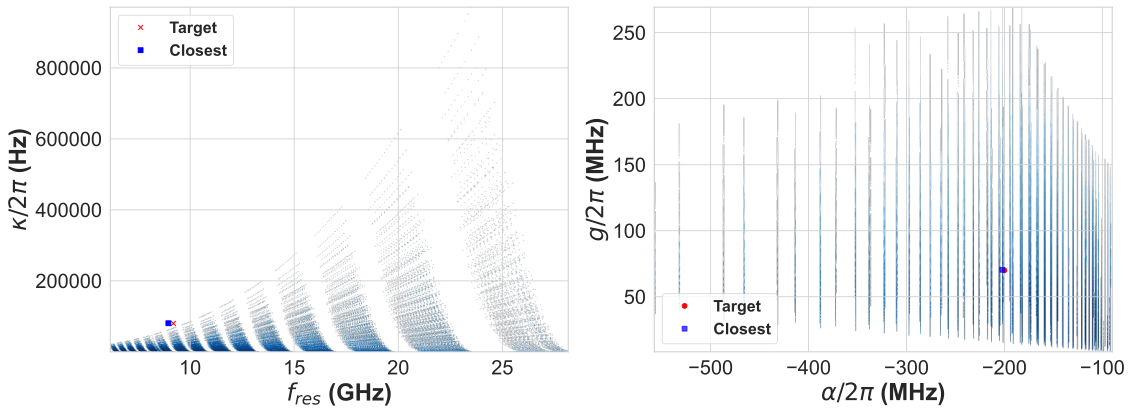

In [62]:
analyzer.closest_design_in_H_space()

#### Interpolation of Best Designs

Even though the `closest_design` will become better as more validated pre-simulated points are added to the database, it is still a good idea to interpolate to get the best designs.

We use the physics inspired interpolation algorithm described in our [paper](https://arxiv.org/pdf/2312.13483.pdf) - `ScalingInterpolator` class to interpolate the best designs.

In [63]:
from squadds.interpolations.physics import ScalingInterpolator

We pass the `Analzyer` object and the `target_params` dict to the `ScalingInterpolator` class.

In [64]:
# Create an instance of ScalingInterpolator
interpolator = ScalingInterpolator(analyzer, target_params)

design_df = interpolator.get_design()

Either `skip_df_gen` flag is set to True or all target params have been precomputed at an earlier step. Using `df` from memory.
Please set this to False if `target_parameters` have changed.
Using 10 CPUs for parallel processing


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 /Users/shanto/LFL/SQuADDS_Refactor/squadds/core/analysis.py: 450


Either `skip_df_gen` flag is set to True or all target params have been precomputed at an earlier step. Using `df` from memory.
Please set this to False if `target_parameters` have changed.
Using 10 CPUs for parallel processing


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 /Users/shanto/LFL/SQuADDS_Refactor/squadds/core/analysis.py: 450


Kappa scaling: 0.9974902538805511
g scaling: 1.000220775604248
alpha scaling: 1.0098680257797241
resonator scaling: 0.9813371948573901


The `design_df` contains the various `design_options` for the best designs and also the `sim_options` needed to simulate them.

In [65]:
design_df

coupler_type                               design_options_qubit  \
0         NCap  {'aedt_hfss_capacitance': 0, 'aedt_hfss_induct...   

                          design_options_cavity_claw  \
0  {'claw_opts': {'connection_pads': {'readout': ...   

                                         setup_qubit  \
0  {'auto_increase_solution_order': True, 'enable...   

                                   setup_cavity_claw  \
0  {'basis_order': 1, 'max_delta_f': 0.05, 'max_p...   

                                      design_options  
0  {'cavity_claw_options': {'coupler_type': 'NCap...

Let's use this interpolated deisgn to generate a `.gds` file.

 /Users/shanto/LFL/SQuADDS_Refactor/.venv/lib/python3.11/site-packages/qiskit_metal/qgeometries/qgeometries_handler.py: 528
 /Users/shanto/LFL/SQuADDS_Refactor/.venv/lib/python3.11/site-packages/qiskit_metal/qgeometries/qgeometries_handler.py: 528
 /Users/shanto/LFL/SQuADDS_Refactor/.venv/lib/python3.11/site-packages/qiskit_metal/renderers/renderer_mpl/mpl_renderer.py: 469
 /Users/shanto/LFL/SQuADDS_Refactor/.venv/lib/python3.11/site-packages/qiskit_metal/renderers/renderer_mpl/mpl_renderer.py: 470
 /Users/shanto/LFL/SQuADDS_Refactor/.venv/lib/python3.11/site-packages/qiskit_metal/renderers/renderer_mpl/mpl_renderer.py: 469
 /Users/shanto/LFL/SQuADDS_Refactor/.venv/lib/python3.11/site-packages/qiskit_metal/renderers/renderer_mpl/mpl_renderer.py: 470
 /Users/shanto/LFL/SQuADDS_Refactor/.venv/lib/python3.11/site-packages/qiskit_metal/renderers/renderer_mpl/mpl_renderer.py: 281


There might be "kinks" in the CPW, which is a known issue in `qiskit-metal`.
To resolve this, try adjusting the `start_straight` or `end_straight` parameters.
For more details and resolution tips, check out this guide:
https://qiskit-community.github.io/qiskit-metal/tut/2-From-components-to-chip/2.12-Simple-Meander.html
There might be "kinks" in the CPW, which is a known issue in `qiskit-metal`.
To resolve this, try adjusting the `start_straight` or `end_straight` parameters.
For more details and resolution tips, check out this guide:
https://qiskit-community.github.io/qiskit-metal/tut/2-From-components-to-chip/2.12-Simple-Meander.html


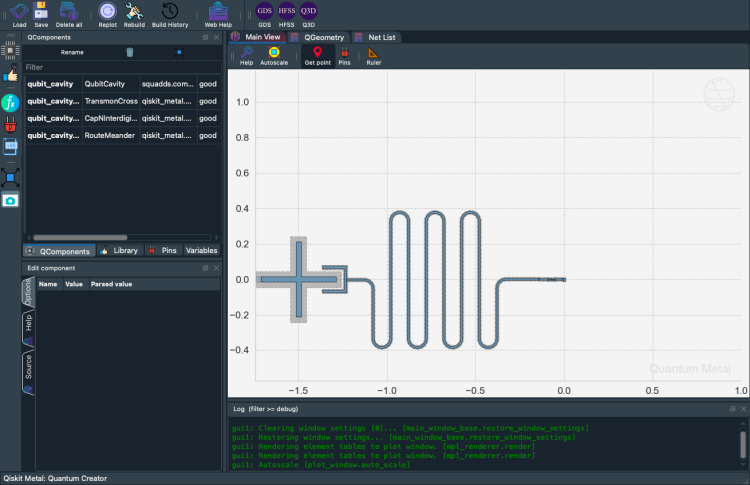

In [66]:
from qiskit_metal import MetalGUI

from squadds.components.coupled_systems import QubitCavity

design = metal.designs.design_planar.DesignPlanar()
gui = metal.MetalGUI(design)
design.overwrite_enabled = True

qc_ncap = QubitCavity(design, "qubit_cavity", options=design_df.iloc[0]["design_options"])
gui.rebuild()
gui.autoscale()
gui.screenshot("qubit_half_wave_cavity")

 /Users/shanto/LFL/SQuADDS_Refactor/.venv/lib/python3.11/site-packages/qiskit_metal/renderers/renderer_mpl/mpl_renderer.py: 469
 /Users/shanto/LFL/SQuADDS_Refactor/.venv/lib/python3.11/site-packages/qiskit_metal/renderers/renderer_mpl/mpl_renderer.py: 470
 /Users/shanto/LFL/SQuADDS_Refactor/.venv/lib/python3.11/site-packages/qiskit_metal/renderers/renderer_mpl/mpl_renderer.py: 469
 /Users/shanto/LFL/SQuADDS_Refactor/.venv/lib/python3.11/site-packages/qiskit_metal/renderers/renderer_mpl/mpl_renderer.py: 470
 /Users/shanto/LFL/SQuADDS_Refactor/.venv/lib/python3.11/site-packages/qiskit_metal/renderers/renderer_mpl/mpl_renderer.py: 281


There might be "kinks" in the CPW, which is a known issue in `qiskit-metal`.
To resolve this, try adjusting the `start_straight` or `end_straight` parameters.
For more details and resolution tips, check out this guide:
https://qiskit-community.github.io/qiskit-metal/tut/2-From-components-to-chip/2.12-Simple-Meander.html


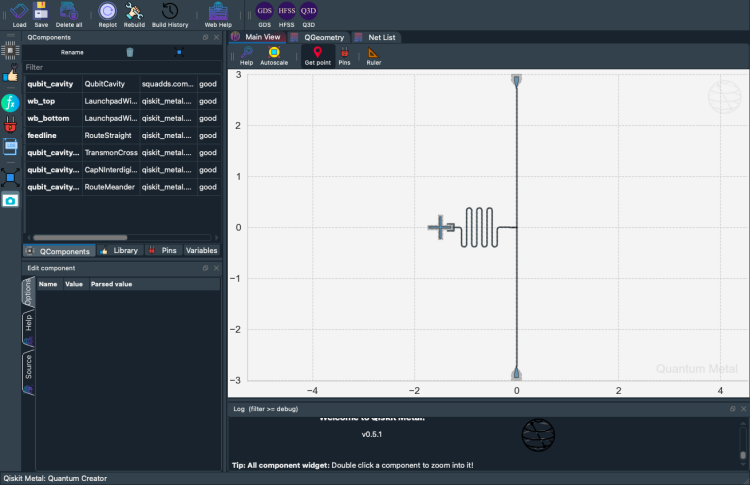

In [67]:
qc_ncap.show(gui, include_wirebond_pads=True)

In [68]:
qc_ncap.to_gds("qubit_cavity", include_wirebond_pads=False)

 /Users/shanto/LFL/SQuADDS_Refactor/.venv/lib/python3.11/site-packages/qiskit_metal/renderers/renderer_gds/gds_renderer.py: 688
 /Users/shanto/LFL/SQuADDS_Refactor/.venv/lib/python3.11/site-packages/qiskit_metal/renderers/renderer_gds/gds_renderer.py: 692
01:49PM 07s WARNING [import_junction_gds_file]: Not able to find file:"../resources/Fake_Junctions.GDS".  Not used to replace junction. Checked directory:"/Users/shanto/LFL/SQuADDS_Refactor/resources".


Congrats for making it to the end of this tutorial! 🤗🎉 You have now learned how to use the SQuADDS API to query for closest and "best-guess" interpolated device designs for your chosen Hamiltonian parameters.

## Next Steps...

In the next [tutorial](https://lfl-lab.github.io/SQuADDS/source/tutorials/Tutorial-2_Simulate_interpolated_designs.html), we will learn how to simulate the "best-guess" design using an EM solver tool and the `SQuADDS` API.

## License

<div style='width: 100%; background-color:#3cb1c2;color:#324344;padding-left: 10px; padding-bottom: 10px; padding-right: 10px; padding-top: 5px'>
    <h3>This code is a part of SQuADDS</h3>
    <p>Developed by Sadman Ahmed Shanto</p>
    <p>This tutorial is written by Sadman Ahmed Shanto</p> 
    <p>&copy; Copyright Sadman Ahmed Shanto & Eli Levenson-Falk 2023.</p>
    <p>This code is licensed under the MIT License. You may<br> obtain a copy of this license in the LICENSE.txt file in the root directory<br> of this source tree.</p>
    <p>Any modifications or derivative works of this code must retain this<br>copyright notice, and modified files need to carry a notice indicating<br>that they have been altered from the originals.</p>
</div>